In [ ]:
!pip install SImpleITK pyradiomics

In [ ]:
from tqdm.notebook import tqdm
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import SimpleITK as sitk
import radiomics
from PIL import Image
from radiomics import firstorder, glcm, shape, glrlm, glszm, ngtdm, gldm, featureextractor
import logging
radiomics.logger.setLevel(logging.ERROR)

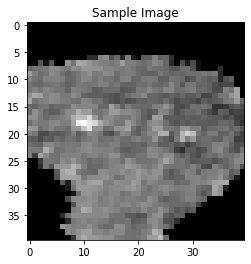

In [ ]:
data_dir = './T2ax'
img_paths = glob(os.path.join(data_dir, '*'))

plt.imshow(Image.open(img_paths[0]), 'gray')
plt.title('Sample Image')
plt.show()

In [ ]:
info_df = pd.DataFrame(img_paths, columns=['img_path'])
info_df['patientid'] = info_df['img_path'].apply(lambda x: x.split(os.sep)[-1].split('-')[1][:4])
info_df['label'] = info_df['img_path'].apply(lambda x: x.split(os.sep)[-1].split('_')[1])
info_df.head()

,img_path,patientid,label
0,./T2ax/ProstateX-0153_1_T2ax_11_rot25.png,0153,1
1,./T2ax/ProstateX-0124_1_T2ax_12_rot5.png,0124,1
2,./T2ax/ProstateX-0105_1_T2ax_13_rot30.png,0105,1
3,./T2ax/ProstateX-0031_1_T2ax_5_rot-15.png,0031,1
4,./T2ax/ProstateX-0084_2_T2ax_6_rot-20.png,0084,2


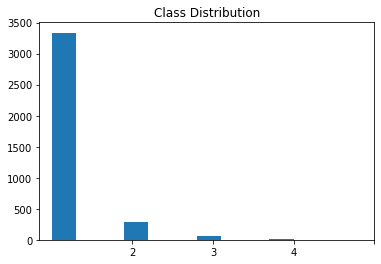

In [ ]:
plt.hist(info_df['label'])
plt.title('Class Distribution')
plt.xticks([1., 2., 3., 4])
plt.show()

In [ ]:
def feature_extract(img_path, voxel = (1,1,1), features = ['firstorder', 'glcm', 'glszm', 'glrlm', 'ngtdm', 'shape']):
    '''
    :param image_path: image_array (numpy array)
    :param image_mask: mask_array (numpy array)
    :return: whole features, featureVector
    '''
    image = np.array(Image.open(img_path))[..., None]
    mask = np.ones_like(image)
    mask[0,:,:] = 0
    mask[39,:,:] = 0
    mask[:,0,:] = 0
    mask[:,39,:] = 0
    image = sitk.GetImageFromArray(image)
    mask = sitk.GetImageFromArray(mask)
    settings = {}
    settings['binwidth'] = 5
    settings['resampledPixelSpacing'] = None
    settings['interpolator'] = 'sitkLinear'
    settings['verbose'] = True
    
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    extractor.settings['enableCExtensions'] = True
    
    for feature in features:
        extractor.enableFeatureClassByName(feature.lower())

    featureVector = extractor.execute(image, mask)
    
    cols = []; feats = []
    for feature in features:
        for featureName in sorted(featureVector.keys()):
            if feature in featureName:
                cols.append(featureName)
                feats.append(featureVector[featureName])
    return feats, cols

In [ ]:
cnt = 0
for row in tqdm(info_df.iterrows()):
    img_path = row[1]['img_path']
    feats, cols = feature_extract(img_path)

    row_w_feats = pd.DataFrame(pd.concat([row[1], pd.Series(feats, cols)])).T

    if cnt == 0:
        feat_df = row_w_feats
    else:
        feat_df = pd.concat([feat_df, row_w_feats])
    
    cnt += 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# limit data due to time oroblem
mask = slice(None, 1000)
# mask = slice(None, None)

# convert to uint8
y = feat_df['label'].astype(np.uint8)[mask]

# set as subset (binary)
y = [0 if i == 1 else 1 for i in y]

X = feat_df.drop(['img_path', 'patientid', 'label'], axis=1)[mask]

my_scaler = MinMaxScaler().fit(X)
X = my_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, roc_auc_score,classification_report,confusion_matrix,plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {
    'n_estimators': [50, 100],
    'max_depth': range(5, 41, 5),
    'max_features': range(5, 80, 5),
    'class_weight': [{0:0.9 ,1:10}, {0:1.1, 1:10}]

}

clf = RandomForestClassifier(random_state=42)
clf = RandomizedSearchCV(clf, params, scoring='roc_auc', n_iter=50)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

Best Params: {'n_estimators': 50, 'max_features': 40, 'max_depth': 20, 'class_weight': {0: 0.9, 1: 10}}

Test Set Confusion_matrix: 

 [[182   2]
 [ 13   3]]

Classification Report: 

               precision    recall  f1-score   support

      Group1       0.93      0.99      0.96       184
   Group2-5_       0.60      0.19      0.29        16

    accuracy                           0.93       200
   macro avg       0.77      0.59      0.62       200
weighted avg       0.91      0.93      0.91       200

Saving ROC curve...


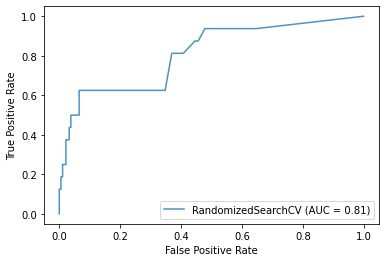

In [ ]:
print('Best Params:', clf.best_params_)
print()

y_pred = clf.predict(X_test)

y_pred_prob = clf.predict_proba(X_test)[:, 0]

print('Test Set Confusion_matrix: \n\n', confusion_matrix(y_test, y_pred))
print('')
print('Classification Report: \n\n', classification_report(y_test, y_pred, target_names=['Group1', 'Group2-5_']))

# plot roc curve
print('Saving ROC curve...')
ax = plt.gca()
rf_roc_curve = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)